In [1]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import libraries
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

import cv2
import numpy as np
from sklearn.cluster import KMeans

from google.colab import files
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow import keras
import ast
import os
import time
import pandas as pd
print("Libraries imported successfully!")

Libraries imported successfully!


Code to access camera from Google Colab provided by Google (with some minor modifications)

In [3]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      //const capture = document.createElement('button');
      //capture.textContent = 'Capture';
      //div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      //document.body.appendChild(div);
      //div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => setTimeout(resolve, 2000));

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
print("Method for taking photos successfully built")

Method for taking photos successfully built


In [20]:
model = tf.keras.models.load_model('/content/drive/My Drive/Proyecto IA/Model/saved_model/my_model')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0

In [115]:
# Brightness detection method.
def rgbBright(img):
    #newImg = np.asarray(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #hsv = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2HSV)
    return hsv[...,2].mean()

# Making a histogram of the colors by grouping them with k cluster.
def make_histogram(cluster):
    """
    Count the number of pixels in each cluster
    :param: KMeans cluster
    :return: numpy histogram
    """
    numLabels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    hist, _ = np.histogram(cluster.labels_, bins=numLabels)
    hist = hist.astype('float32')
    hist /= hist.sum()
    return hist

def make_bar(height, width, color):
    """
    Create an image of a given color
    :param: height of the image
    :param: width of the image
    :param: BGR pixel values of the color
    :return: tuple of bar, rgb values, and hsv values
    """
    bar = np.zeros((height, width, 3), np.uint8)
    bar[:] = color
    red, green, blue = int(color[2]), int(color[1]), int(color[0])
    hsv_bar = cv2.cvtColor(bar, cv2.COLOR_BGR2HSV)
    hue, sat, val = hsv_bar[0][0]
    return bar, (red, green, blue), (hue, sat, val)

def sort_hsvs(hsv_list):
    """
    Sort the list of HSV values
    :param hsv_list: List of HSV tuples
    :return: List of indexes, sorted by hue, then saturation, then value
    """
    bars_with_indexes = []
    for index, hsv_val in enumerate(hsv_list):
        bars_with_indexes.append((index, hsv_val[0], hsv_val[1], hsv_val[2]))
    bars_with_indexes.sort(key=lambda elem: (elem[1], elem[2], elem[3]))
    return [item[0] for item in bars_with_indexes]

def photoAnalyse(img):
    height, width, _ = np.shape(img)

    # Print brightness.
    #print("Brightness")
    #print(str(rgbBright(img)))

    # Reshape the image to be a simple list of RGB pixels.
    image = img.reshape((height * width, 3))

    # We'll pick the 6 most common colors.
    num_clusters = 6
    clusters = KMeans(n_clusters=num_clusters)
    clusters.fit(image)

    # Count the dominant colors and put them in "buckets".
    histogram = make_histogram(clusters)
    # Then sort them, most-common first.
    combined = zip(histogram, clusters.cluster_centers_)
    combined = sorted(combined, key=lambda x: x[0], reverse=True)

    # Finally, we'll output a graphic showing the colors in order.
    bars = []
    hsv_values = []

    for index, rows in enumerate(combined):
        bar, rgb, hsv = make_bar(100, 100, rows[1])
        #print(f'Bar {index + 1}')
        #print(f'  RGB values: {rgb}')
        #print(f'  HSV values: {hsv}')
        hsv_values.append(hsv)
        bars.append(bar)
    #"""
    # Code to view the most common colors and the image taken
    # Sort the bars[] list so that we can show the colored boxes sorted
    # by their HSV values -- sort by hue, then saturation.
    sorted_bar_indexes = sort_hsvs(hsv_values)
    sorted_bars = [bars[idx] for idx in sorted_bar_indexes]
    
    cv2_imshow(np.hstack(sorted_bars))
    

    #"""
    return hsv_values
print("Image analysis methods successfully built")
def probAnalyze(img, model, names, hsv):
  #method to help cnn determine which situation is more likely
  (h, w) = img.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(img, (224, 224)), 1, (224, 224), (104, 117, 123))
  blob = tf.transpose(blob, [0,2,3,1])
  prob = list(tf.nn.softmax(model.predict_proba(blob))[0])
  print(prob)
  print(names)
  cGreen = 0
  cGray = 0
  cWhite = 0
  for x in hsv:
    print(x[0])
    if 60 < x[0] < 150 and x [1] > 60:
      cGreen += 1
    if x[0] > 5 and 25 < x[2]:
      cGray += 1
    if x[2] > 97:
      cWhite += 1
  
  if cGreen > 3:
    prob[names.index("vegetation")] += .6
    prob[names.index("outside")] -= .6
  if cGray > 4:
    prob[names.index("highways")] += .2

  
  m = prob[0]
  print('m\n' + str(m))
  id = 0
  for i in range(1, len(prob)):
    print (prob[i])
    if prob[i] > m:
      m = prob[i]
      id = i
  print(id)
  return (m, names[id])
  
  

Image analysis methods successfully built


/content/drive/My Drive/Proyecto IA/Aditional_Test_Images/33.ludlow-exterior-sfs-900x600.jpg


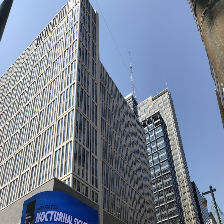

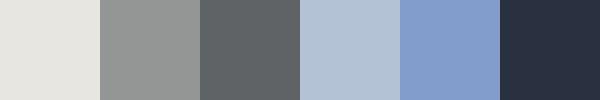

[<tf.Tensor: shape=(), dtype=float32, numpy=9.796416e-07>, <tf.Tensor: shape=(), dtype=float32, numpy=0.3370867>, <tf.Tensor: shape=(), dtype=float32, numpy=0.66267616>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1464034e-06>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00011077117>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3842389e-07>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00012411227>, <tf.Tensor: shape=(), dtype=float32, numpy=5.2558418e-14>, <tf.Tensor: shape=(), dtype=float32, numpy=2.908725e-14>, <tf.Tensor: shape=(), dtype=float32, numpy=3.2461322e-13>, <tf.Tensor: shape=(), dtype=float32, numpy=4.531752e-14>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6675058e-12>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5099906e-11>, <tf.Tensor: shape=(), dtype=float32, numpy=8.79402e-15>]
['bedroom', 'outside', 'vegetation', 'highways', 'livingroom', 'skyline', 'water_bodies']
109
105
110
107
75
21
m
tf.Tensor(9.796416e-07, shape=(), dtype=float32)
tf.Tensor(0.3370867, s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [133]:
import pathlib
def main():
  dir = "/content/drive/My Drive/Proyecto IA/"
  data_dir = pathlib.Path(dir)
  images = list(data_dir.glob('Aditional_Test_Images/*'))
  image = images[np.random.randint(0,len(images))]
  print(image)
  img = cv2.imread(str(image))
  img = cv2.resize(img, (224,224))
  cv2_imshow(img)
  names = ['bedroom', 'outside', 'vegetation', 'highways', 'livingroom', 'skyline', 'water_bodies']
  hsv = photoAnalyse(img)
  pred = probAnalyze(img, model, names, hsv)
  print(pred)
main()